Students Name: 
- Salam ALKAISSI
- Mayra Suarez

In [1]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 79.9 MB/s eta 0:00:00


In [3]:
import rasterio
import numpy as np

# Load the mean LST image
mean_file = '/content/drive/MyDrive/EarthObservation_LST/Ile_de_France_LST_Mean_2019.tif'
with rasterio.open(mean_file) as src:
    mean_data = src.read(1)  # Read the first band

# Since this is a mean image, it doesn't have first/latest days
print("Note: This is a mean LST image for 2019. No first/latest day data available.")
print(f"Mean LST for 2019: {np.nanmean(mean_data):.2f} °C")
print(f"Min LST: {np.nanmin(mean_data):.2f} °C")
print(f"Max LST: {np.nanmax(mean_data):.2f} °C")

Note: This is a mean LST image for 2019. No first/latest day data available.
Mean LST for 2019: 17.58 °C
Min LST: 14.38 °C
Max LST: 23.72 °C


In [24]:
import rasterio
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from matplotlib.colors import LinearSegmentedColormap
import os

# 1. Define paths and parameters
tif_files = [
    '/content/drive/MyDrive/GEE_Exports/LST_Month_6.tif',
    '/content/drive/MyDrive/GEE_Exports/LST_Month_7.tif',
    '/content/drive/MyDrive/GEE_Exports/LST_Month_8.tif'
]
output_gif = '/content/drive/MyDrive/EarthObservation_LST/lst_animation.gif'

# 2. Custom colormap
palette = [
    '#040274', '#040281', '#0502a3', '#0502b8', '#0502ce', '#0502e6',
    '#0602ff', '#235cb1', '#307ef3', '#269db1', '#30c8e2', '#32d3ef',
    '#3be285', '#3ff38f', '#86e26f', '#3ae237', '#b5e22e', '#d6e21f',
    '#fff705', '#ffd611', '#ffb613', '#ff8b13', '#ff6e08', '#ff500d',
    '#ff0000', '#de0101', '#c21301', '#a71001', '#911003'
]
cmap = LinearSegmentedColormap.from_list('gee_lst', palette)

# 3. Load font for annotation
try:
    font = ImageFont.truetype("arial.ttf", 20)
except:
    font = ImageFont.load_default()

# 4. Process each TIFF file
images = []
for tif_path in tif_files:
    try:
        with rasterio.open(tif_path) as src:
            # Read the single band
            data = src.read(1)

            # Extract month from filename (assuming format "LST_Month_X.tif")
            month = os.path.basename(tif_path).split('_')[-1].split('.')[0]

            # Normalization and masking
            mask = (data < 18.47) | (data > 42.86)
            norm_data = np.ma.masked_array(data, mask=mask)
            norm_data = (norm_data - 18.47) / (42.86 - 18.47) * 255
            norm_data = norm_data.filled(0).astype(np.uint8)

            # Apply colormap
            colored = (cmap(norm_data/255)[:, :, :3] * 255)
            img = Image.fromarray(colored.astype(np.uint8))

            # Add text annotation with actual month
            draw = ImageDraw.Draw(img)
            draw.text((10, 10),
                     f"2019-{month}",
                     fill=(255, 255, 255),
                     font=font)

            images.append(img)
    except Exception as e:
        print(f"Error processing {tif_path}: {str(e)}")

# 5. Save as GIF
if images:
    images[0].save(
        output_gif,
        save_all=True,
        append_images=images[1:],
        duration=500,
        loop=0,
        optimize=True
    )
    print(f"GIF created successfully with {len(images)} frames")
else:
    print("No valid images processed")

GIF created successfully with 3 frames


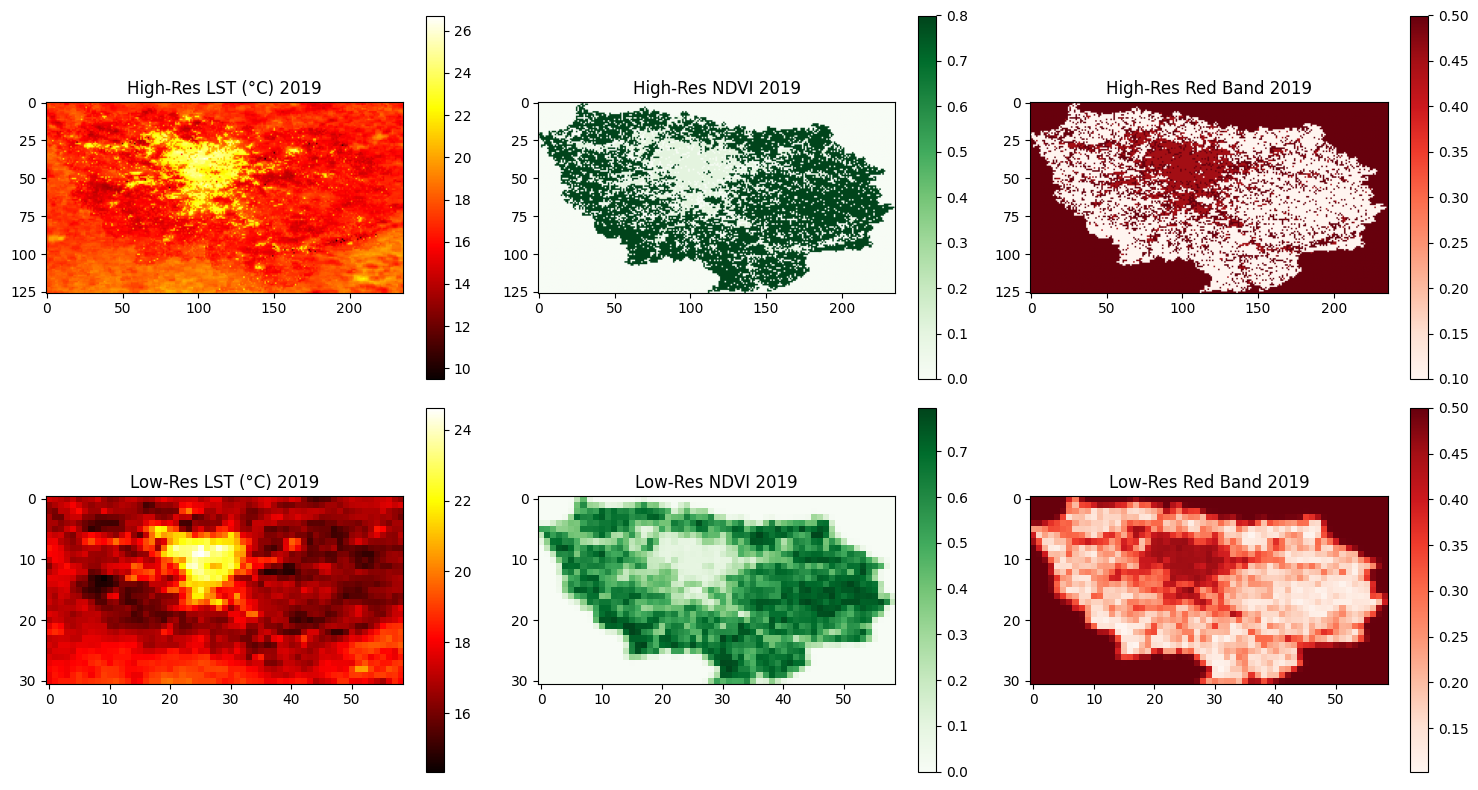

In [5]:
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt
import rasterio

# Load the Île-de-France LST data for 2019
lst_path = "/content/drive/MyDrive/EarthObservation_LST/Ile_de_France_LST_Mean_2019.tif"
with rasterio.open(lst_path) as dataset:
    high_res_lst = dataset.read(1)  # Read the first band (LST in Celsius)
    profile = dataset.profile  # Save the profile for later use
    transform = dataset.transform

# Clean the LST data
high_res_lst = np.where(high_res_lst < -100, np.nan, high_res_lst)

# Load the land cover masks for 2019
urban_mask_path = "/content/drive/MyDrive/EarthObservation_LST/Ile_de_France_Urban_Mask_2019.tif"
vegetation_mask_path = "/content/drive/MyDrive/EarthObservation_LST/Ile_de_France_Vegetation_Mask_2019.tif"
water_mask_path = "/content/drive/MyDrive/EarthObservation_LST/Ile_de_France_Water_Mask_2019.tif"

with rasterio.open(urban_mask_path) as dataset:
    urban_mask = dataset.read(1)
with rasterio.open(vegetation_mask_path) as dataset:
    vegetation_mask = dataset.read(1)
with rasterio.open(water_mask_path) as dataset:
    water_mask = dataset.read(1)

# Ensure masks are aligned with LST data (resize if necessary)
urban_mask = resize(urban_mask, high_res_lst.shape, anti_aliasing=False, preserve_range=True).astype(np.uint8)
vegetation_mask = resize(vegetation_mask, high_res_lst.shape, anti_aliasing=False, preserve_range=True).astype(np.uint8)
water_mask = resize(water_mask, high_res_lst.shape, anti_aliasing=False, preserve_range=True).astype(np.uint8)

# Simulate high-resolution LST with temperature variations
# Urban areas: warmer (+3°C), Vegetation: slightly cooler (-1°C), Water: cooler (-5°C)
high_res_lst_simulated = high_res_lst.copy()
high_res_lst_simulated = np.where(np.isnan(high_res_lst_simulated), 20, high_res_lst_simulated)  # Replace NaN with a baseline temperature
high_res_lst_simulated = high_res_lst_simulated + (urban_mask * 3)  # Urban warming
high_res_lst_simulated = high_res_lst_simulated - (vegetation_mask * 1)  # Vegetation cooling
high_res_lst_simulated = high_res_lst_simulated - (water_mask * 5)  # Water cooling

# Simulate high-resolution NDVI based on land cover
# Urban: low NDVI (0.1), Vegetation: high NDVI (0.8), Water: very low NDVI (0.05)
high_res_ndvi = np.zeros_like(high_res_lst)
high_res_ndvi = high_res_ndvi + (urban_mask * 0.1)
high_res_ndvi = high_res_ndvi + (vegetation_mask * 0.8)
high_res_ndvi = high_res_ndvi + (water_mask * 0.05)

# Simulate high-resolution Red and NIR bands (simplified reflectance values)
# NDVI = (NIR - Red) / (NIR + Red) -> Solve for Red and NIR
# Assume NIR + Red = 1 for simplicity, then: NIR = (1 + NDVI) / 2, Red = (1 - NDVI) / 2
high_res_nir = (1 + high_res_ndvi) / 2
high_res_red = (1 - high_res_ndvi) / 2

# Downsample all high-resolution data to create low-resolution versions (1/4 resolution)
low_res_lst = resize(high_res_lst_simulated, (high_res_lst.shape[0]//4, high_res_lst.shape[1]//4), anti_aliasing=True)
low_res_ndvi = resize(high_res_ndvi, (high_res_lst.shape[0]//4, high_res_lst.shape[1]//4), anti_aliasing=True)
low_res_red = resize(high_res_red, (high_res_lst.shape[0]//4, high_res_lst.shape[1]//4), anti_aliasing=True)
low_res_nir = resize(high_res_nir, (high_res_lst.shape[0]//4, high_res_lst.shape[1]//4), anti_aliasing=True)

# Plot the results
plt.figure(figsize=(15, 8))

plt.subplot(2, 3, 1)
plt.imshow(high_res_lst_simulated, cmap='hot')
plt.title("High-Res LST (°C) 2019")
plt.colorbar()

plt.subplot(2, 3, 2)
plt.imshow(high_res_ndvi, cmap='Greens')
plt.title("High-Res NDVI 2019")
plt.colorbar()

plt.subplot(2, 3, 3)
plt.imshow(high_res_red, cmap='Reds')
plt.title("High-Res Red Band 2019")
plt.colorbar()

plt.subplot(2, 3, 4)
plt.imshow(low_res_lst, cmap='hot')
plt.title("Low-Res LST (°C) 2019")
plt.colorbar()

plt.subplot(2, 3, 5)
plt.imshow(low_res_ndvi, cmap='Greens')
plt.title("Low-Res NDVI 2019")
plt.colorbar()

plt.subplot(2, 3, 6)
plt.imshow(low_res_red, cmap='Reds')
plt.title("Low-Res Red Band 2019")
plt.colorbar()

plt.tight_layout()
plt.show()

# Save the dataset for further use
np.savez('/content/drive/MyDrive/EarthObservation_LST/Ile_de_France_Dataset_2019.npz',
         high_res_lst=high_res_lst_simulated,
         high_res_ndvi=high_res_ndvi,
         high_res_red=high_res_red,
         high_res_nir=high_res_nir,
         low_res_lst=low_res_lst,
         low_res_ndvi=low_res_ndvi,
         low_res_red=low_res_red,
         low_res_nir=low_res_nir)

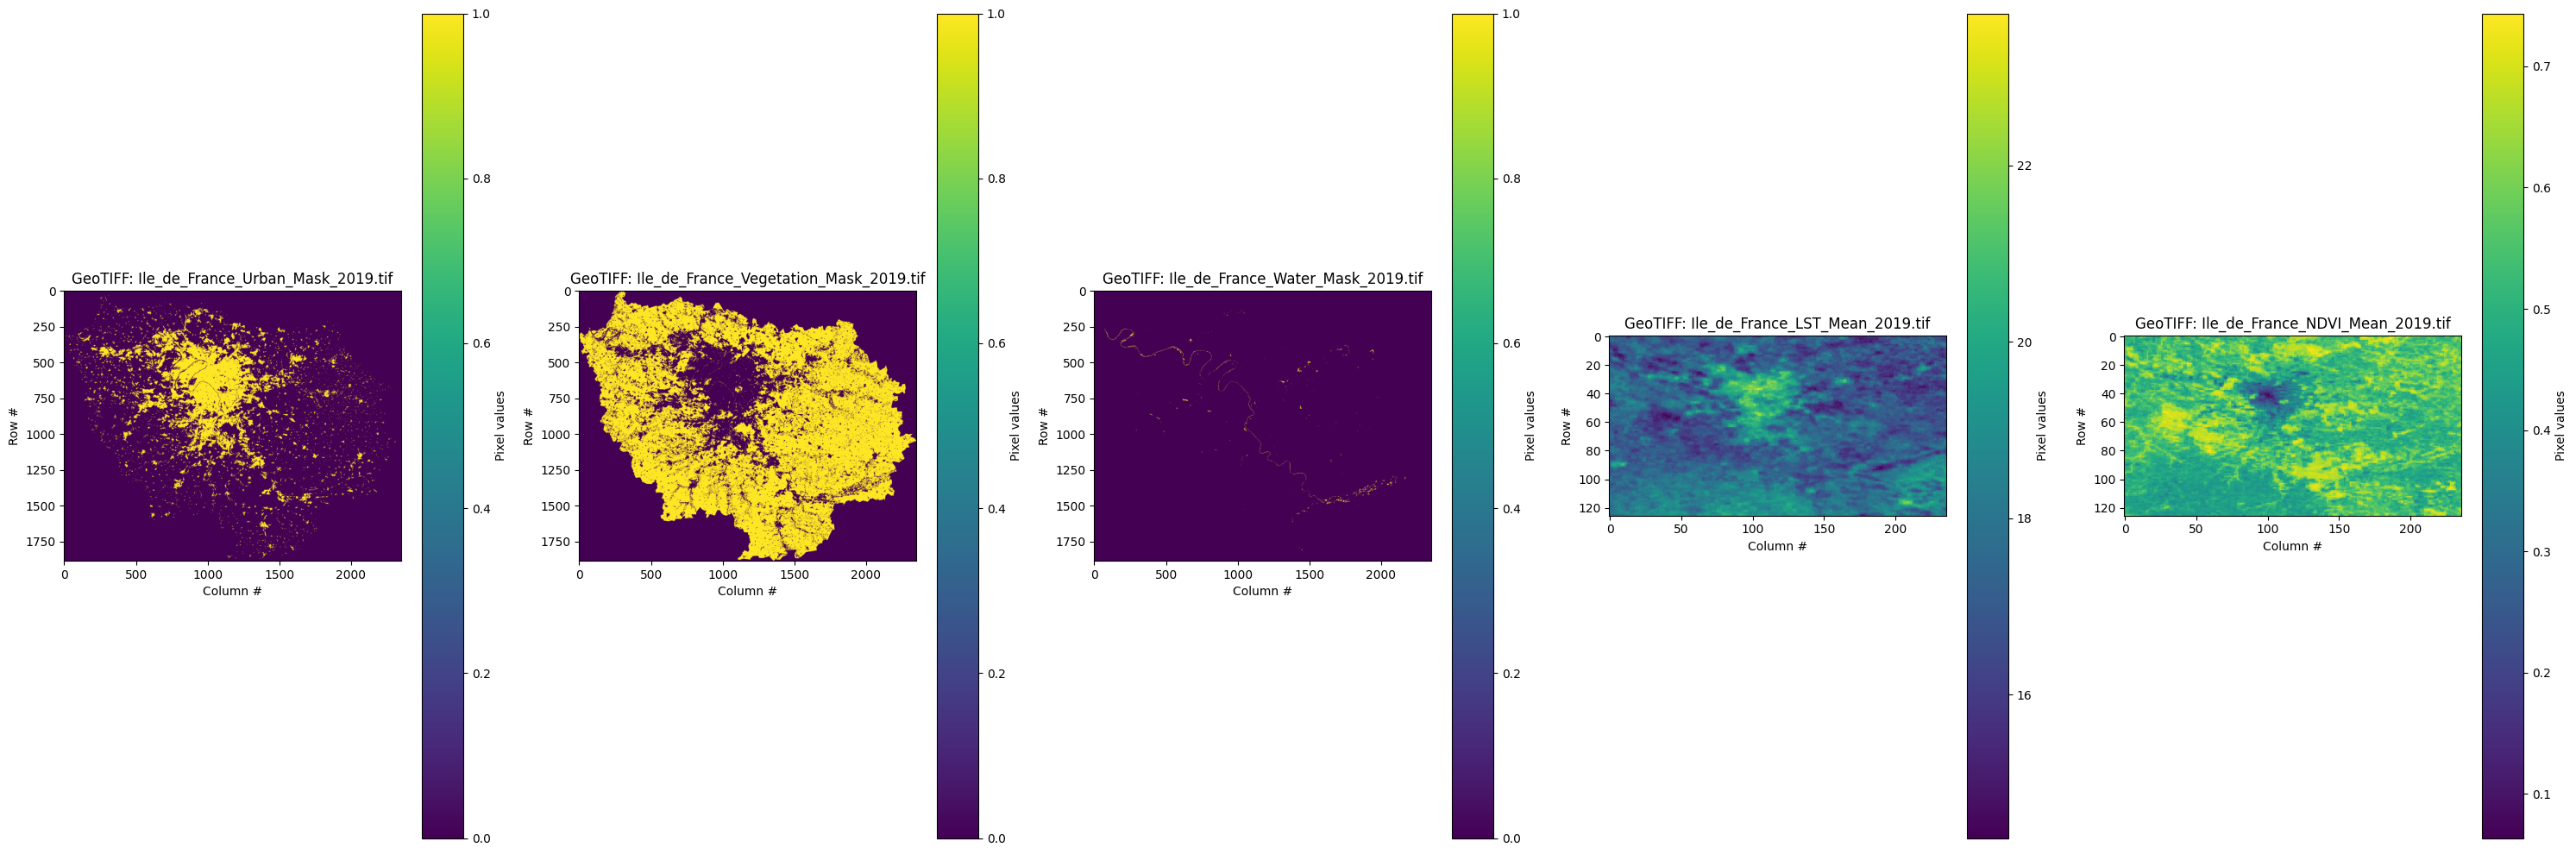

In [44]:
def show_geotiffs_side_by_side(file_paths):
    """Read and display multiple GeoTIFF files side by side."""
    # Create a figure with 3 subplots side by side
    fig, axes = plt.subplots(1, 5, figsize=(30, 10))

    for i, file_path in enumerate(file_paths):
        # Read the GeoTIFF file
        with rasterio.open(file_path) as src:
            data = src.read(1)

            # Display the image in the corresponding subplot
            im = axes[i].imshow(data, cmap='viridis')
            axes[i].set_title(f'GeoTIFF: {file_path.split("/")[-1]}')
            axes[i].set_xlabel('Column #')
            axes[i].set_ylabel('Row #')

            # Add a colorbar for each subplot
            fig.colorbar(im, ax=axes[i], label='Pixel values')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# List of GeoTIFF file paths
file_paths = [
    '/content/drive/My Drive/EarthObservation_LST/Ile_de_France_Urban_Mask_2019.tif',
    '/content/drive/My Drive/EarthObservation_LST/Ile_de_France_Vegetation_Mask_2019.tif',
    '/content/drive/My Drive/EarthObservation_LST/Ile_de_France_Water_Mask_2019.tif',
    '/content/drive/MyDrive/EarthObservation_LST/Ile_de_France_LST_Mean_2019.tif',
    '/content/drive/MyDrive/EarthObservation_LST/Ile_de_France_NDVI_Mean_2019.tif'
]

# Display the GeoTIFFs side by side
show_geotiffs_side_by_side(file_paths)

##  Enhancing Spatial Resolution of Land Surface Temperature (LST)

This notebook aims to improve the spatial resolution of Land Surface Temperature (LST) data using machine learning, focusing on data fusion techniques. It explores various methods to sharpen LST images by combining them with higher-resolution data like NDVI (Normalized Difference Vegetation Index) and other spectral bands.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from skimage.transform import resize
import scipy.stats as stats
import os

In [7]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [8]:
!pip install sentinelsat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 3.9 MB/s eta 0:00:00


In [9]:
# Clone the repo
!git clone https://github.com/sentinelsat/sentinelsat.git

# Change directory and install in editable mode with dev dependencies
%cd sentinelsat
!pip install -e .[dev]

# Run tests using pytest
!pytest -v

Cloning into 'sentinelsat'...
remote: Enumerating objects: 6595, done.
remote: Counting objects: 100% (1464/1464), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 6595 (delta 1365), reused 1344 (delta 1338), pack-reused 5131 (from 1)
Receiving objects: 100% (6595/6595), 28.56 MiB | 25.67 MiB/s, done.
Resolving deltas: 100% (4741/4741), done.
/content/sentinelsat
Obtaining file:///content/sentinelsat
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of sphinx to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of sphinx to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the depe

### Generates synthetic LST, NDVI, Red, and NIR data:
1. Creates land cover masks (urban, vegetation, water).
2. Simulates high-resolution LST with temperature variations.
3. Simulates high-resolution NDVI based on land cover.
4. Simulates Red and NIR bands.
5. Downsamples all high-resolution data to create low-resolution versions.

In [ ]:
import numpy as np
import rasterio
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras import layers, models
import tensorflow as tf
from scipy.interpolate import griddata
from scipy.stats import linregress
from sklearn.ensemble import RandomForestRegressor


**Need to Run the following commented ccode and replaced the generate_synthetic data**

In [ ]:

# Load LST image
lst_path = "/content/drive/MyDrive/EarthObservation_LST/Ile_de_France_LST_Mean_2019.tif"
with rasterio.open(lst_path) as lst_src:
    lst_real = lst_src.read(1)

# Load NDVI image
ndvi_path = "/content/drive/MyDrive/EarthObservation_LST/Ile_de_France_NDVI_Mean_2019.tif"
with rasterio.open(ndvi_path) as ndvi_src:
    ndvi_real = ndvi_src.read(1)

# Normalize or clip if necessary
lst_real = np.where(lst_real < 0, np.nan, lst_real)  # Remove no-data for LST
ndvi_real = np.clip(ndvi_real, 0, 1)  # Ensure NDVI is in [0, 1]

In [11]:
from skimage.transform import resize

scale_factor = 4
lr_shape = (lst_real.shape[0] // scale_factor, lst_real.shape[1] // scale_factor)

lr_lst_real = resize(lst_real, lr_shape, anti_aliasing=True)
lr_ndvi_real = resize(ndvi_real, lr_shape, anti_aliasing=True)


In [12]:
# data = {
#     'hr_lst': lst_real,
#     'lr_lst': lr_lst_real,
#     'hr_ndvi': ndvi_real,
#     'lr_ndvi': lr_ndvi_real
#     # 'hr_red': red_real,       # Optional: load if available
#     # 'lr_red': lr_red_real,    # Optional
#     # 'hr_nir': nir_real,       # Optional
#     # 'lr_nir': lr_nir_real     # Optional
# }
data = {
    'hr_lst': lst_real,
    'lr_lst': lr_lst_real,
    'hr_ndvi': ndvi_real,
    'lr_ndvi': lr_ndvi_real
}

Generating synthetic Earth observation data...


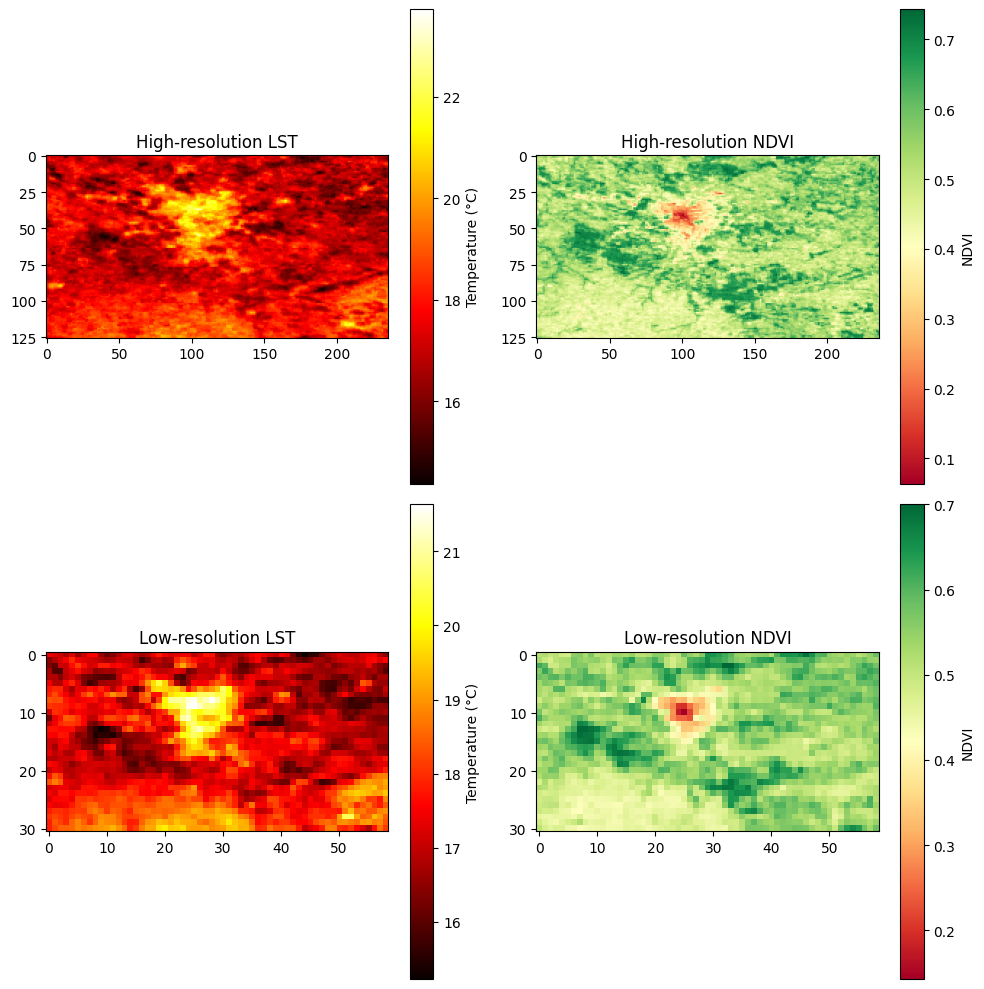

In [ ]:
# Function to generate synthetic data for LST super-resolution experiments
def generate_synthetic_data(size=128, scale_factor=4):
    """
    Generate synthetic data for LST super-resolution experiments

    Parameters:
    - size: Size of the high-resolution image
    - scale_factor: Downsampling factor to create the low-resolution image

    Returns:
    - hr_lst: High-resolution LST image
    - lr_lst: Low-resolution LST image
    - hr_ndvi: High-resolution NDVI image
    - lr_ndvi: Low-resolution NDVI image
    """
    # Generate a synthetic landscape with various temperature patterns
    x, y = np.meshgrid(np.linspace(0, 1, size), np.linspace(0, 1, size))

    # Create temperature pattern (higher in urban areas, lower in vegetation)
    urban_mask = (x - 0.5)**2 + (y - 0.5)**2 < 0.15**2
    vegetation_mask = ((x - 0.2)**2 + (y - 0.7)**2 < 0.1**2) | ((x - 0.8)**2 + (y - 0.3)**2 < 0.12**2)
    water_mask = (x - 0.7)**2 + (y - 0.7)**2 < 0.08**2

    # Base temperature (degrees Celsius)
    hr_lst = np.ones((size, size)) * 25

    # Add temperature variations
    hr_lst[urban_mask] += 8  # Urban areas are hotter
    hr_lst[vegetation_mask] -= 5  # Vegetation areas are cooler
    hr_lst[water_mask] -= 10  # Water bodies are much cooler

    # Add some noise and spatial smoothing for realism
    hr_lst += np.random.normal(0, 0.5, (size, size))
    hr_lst = gaussian_filter(hr_lst, sigma=1)

    # Create NDVI data (inversely related to temperature)
    hr_ndvi = np.zeros((size, size))
    hr_ndvi[vegetation_mask] = 0.8  # High NDVI for vegetation
    hr_ndvi[urban_mask] = 0.2  # Low NDVI for urban areas
    hr_ndvi[water_mask] = 0.0  # Very low NDVI for water

    # Add gradients and noise to NDVI
    x_grad, y_grad = np.meshgrid(np.linspace(0, 0.3, size), np.linspace(0, 0.3, size))
    hr_ndvi += x_grad * (1 - urban_mask) * (1 - water_mask) * 0.5
    hr_ndvi += np.random.normal(0, 0.05, (size, size))
    hr_ndvi = np.clip(hr_ndvi, 0, 1)  # NDVI ranges from 0 to 1
    hr_ndvi = gaussian_filter(hr_ndvi, sigma=1)

    # Create additional bands for multi-spectral data (simplified)
    # Red band (higher in urban areas, lower in vegetation)
    red_band = np.ones((size, size)) * 0.3
    red_band[urban_mask] = 0.6
    red_band[vegetation_mask] = 0.1
    red_band[water_mask] = 0.05
    red_band += np.random.normal(0, 0.02, (size, size))
    red_band = np.clip(red_band, 0, 1)

    # Near infrared band (higher in vegetation, lower in water)
    nir_band = np.ones((size, size)) * 0.4
    nir_band[vegetation_mask] = 0.8
    nir_band[urban_mask] = 0.3
    nir_band[water_mask] = 0.1
    nir_band += np.random.normal(0, 0.02, (size, size))
    nir_band = np.clip(nir_band, 0, 1)

    # Downsampling to create low-resolution images
    lr_size = size // scale_factor
    lr_lst = resize(hr_lst, (lr_size, lr_size), anti_aliasing=True)
    lr_ndvi = resize(hr_ndvi, (lr_size, lr_size), anti_aliasing=True)
    lr_red = resize(red_band, (lr_size, lr_size), anti_aliasing=True)
    lr_nir = resize(nir_band, (lr_size, lr_size), anti_aliasing=True)

    return {
        'hr_lst': hr_lst,
        'lr_lst': lr_lst,
        'hr_ndvi': hr_ndvi,
        'lr_ndvi': lr_ndvi
        # 'hr_red': red_band,
        # 'lr_red': lr_red,
        # 'hr_nir': nir_band,
        # 'lr_nir': lr_nir
    }

# Generate our synthetic data
print("Generating synthetic Earth observation data...")
data = generate_synthetic_data(size=256, scale_factor=4)

# Visualize the synthetic data
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

im1 = axes[0, 0].imshow(lst_real, cmap='hot')
axes[0, 0].set_title('High-resolution LST')
plt.colorbar(im1, ax=axes[0, 0], label='Temperature (°C)')

im2 = axes[0, 1].imshow(ndvi_real, cmap='RdYlGn')
axes[0, 1].set_title('High-resolution NDVI')
plt.colorbar(im2, ax=axes[0, 1], label='NDVI')

im3 = axes[1, 0].imshow(lr_lst_real, cmap='hot')
axes[1, 0].set_title('Low-resolution LST')
plt.colorbar(im3, ax=axes[1, 0], label='Temperature (°C)')

im4 = axes[1, 1].imshow(lr_ndvi_real, cmap='RdYlGn')
axes[1, 1].set_title('Low-resolution NDVI')
plt.colorbar(im4, ax=axes[1, 1], label='NDVI')

plt.tight_layout()
plt.show()

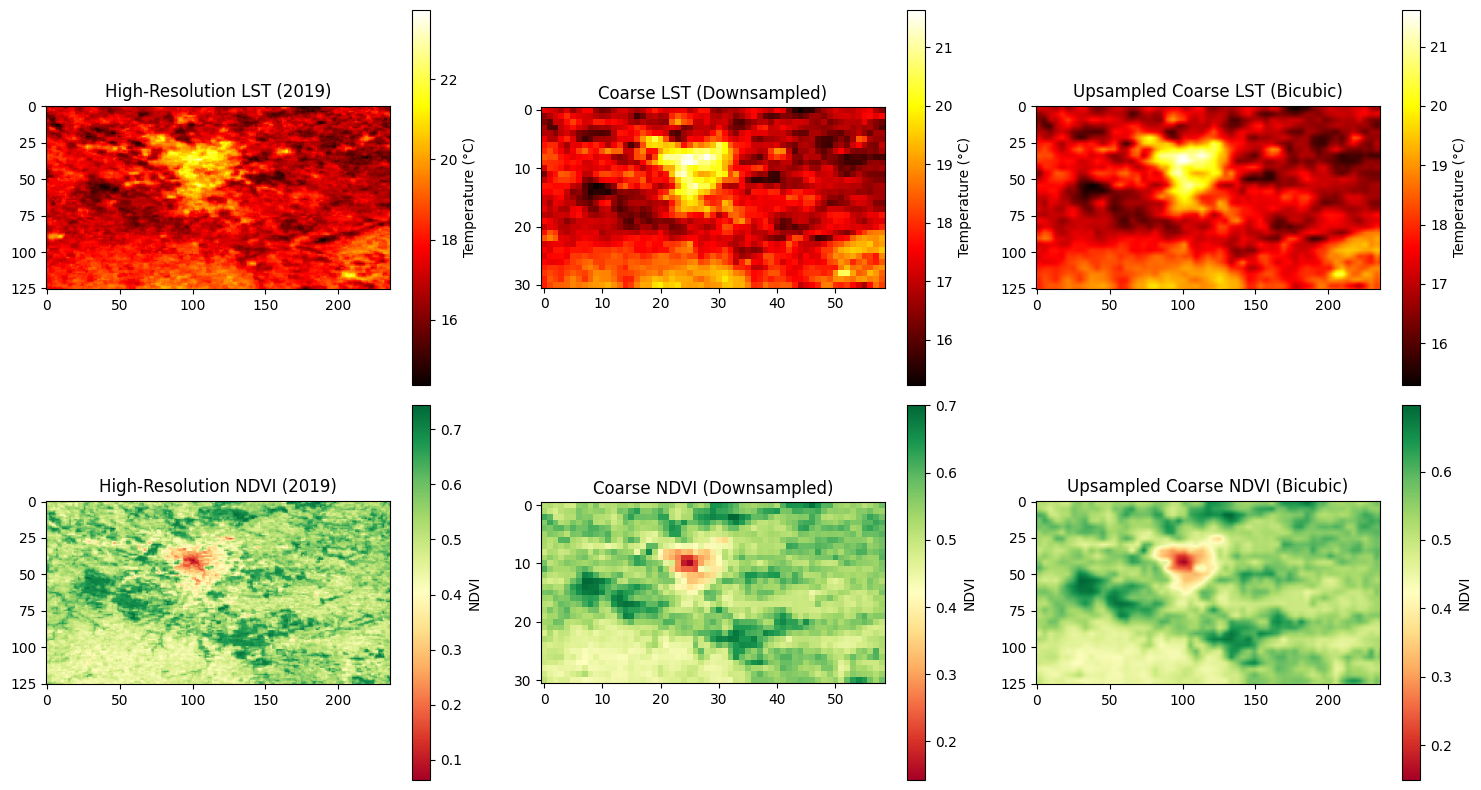

In [14]:
# ==== ADDED VISUALIZATION FOR INITIAL DOWNSAMPLING =====
# Reference variables directly from the real data (avoid synthetic data)
high_res_lst = lst_real      # High-resolution LST
coarse_lst = lr_lst_real     # Low-resolution LST
ndvi_fine = ndvi_real        # High-resolution NDVI
ndvi_coarse = lr_ndvi_real   # Low-resolution NDVI

# Create upsampled versions using bicubic interpolation for comparison
upsampled_lst = resize(coarse_lst, high_res_lst.shape, anti_aliasing=True)
upsampled_ndvi = resize(ndvi_coarse, ndvi_fine.shape, anti_aliasing=True)

# Visualize the downsampling and simple upsampling
plt.figure(figsize=(15, 8))

# High-resolution LST
plt.subplot(2, 3, 1)
plt.imshow(high_res_lst, cmap='hot')
plt.title("High-Resolution LST (2019)")
plt.colorbar(label='Temperature (°C)')

# Coarse LST (downsampled)
plt.subplot(2, 3, 2)
plt.imshow(coarse_lst, cmap='hot')
plt.title("Coarse LST (Downsampled)")
plt.colorbar(label='Temperature (°C)')

# Upsampled LST (bicubic interpolation)
plt.subplot(2, 3, 3)
plt.imshow(upsampled_lst, cmap='hot')
plt.title("Upsampled Coarse LST (Bicubic)")
plt.colorbar(label='Temperature (°C)')

# High-resolution NDVI
plt.subplot(2, 3, 4)
plt.imshow(ndvi_fine, cmap='RdYlGn')
plt.title("High-Resolution NDVI (2019)")
plt.colorbar(label='NDVI')

# Coarse NDVI (downsampled)
plt.subplot(2, 3, 5)
plt.imshow(ndvi_coarse, cmap='RdYlGn')
plt.title("Coarse NDVI (Downsampled)")
plt.colorbar(label='NDVI')

# Upsampled NDVI (bicubic interpolation)
plt.subplot(2, 3, 6)
plt.imshow(upsampled_ndvi, cmap='RdYlGn')
plt.title("Upsampled Coarse NDVI (Bicubic)")
plt.colorbar(label='NDVI')

plt.tight_layout()
plt.show()

In [15]:
# Now let's implement various LST sharpening methods as described in the lecture

# 1. DisTrad (TsHarp) Method
def distrad_tsharp(lr_lst, lr_ndvi, hr_ndvi):
    """
    Implementation of DisTrad (TsHarp) method for LST sharpening

    Parameters:
    - lr_lst: Low-resolution LST image
    - lr_ndvi: Low-resolution NDVI image
    - hr_ndvi: High-resolution NDVI image

    Returns:
    - hr_lst: Sharpened high-resolution LST image
    """
    # Reshape images to 1D arrays for regression
    lr_lst_flat = lr_lst.flatten()
    lr_ndvi_flat = lr_ndvi.flatten()

    # Linear regression between LST and NDVI at low resolution
    slope, intercept, r_value, p_value, std_err = stats.linregress(lr_ndvi_flat, lr_lst_flat)

    print(f"DisTrad Regression: LST = {intercept:.2f} + {slope:.2f} * NDVI (R²: {r_value**2:.2f})")

    # Predict initial high-resolution LST using the regression
    hr_lst_pred = intercept + slope * hr_ndvi

    # Calculate residuals at low resolution
    lr_lst_pred = intercept + slope * lr_ndvi
    residuals_lr = lr_lst - lr_lst_pred

    # Upscale residuals using nearest neighbor interpolation
    hr_shape = hr_ndvi.shape
    lr_shape = lr_lst.shape
    scale_factor = hr_shape[0] // lr_shape[0]

    # Create coordinates for interpolation
    lr_coords = np.array([(i, j) for i in range(lr_shape[0]) for j in range(lr_shape[1])])
    hr_coords = np.array([(i//scale_factor, j//scale_factor)
                          for i in range(hr_shape[0])
                          for j in range(hr_shape[1])])

    # Perform nearest neighbor interpolation of residuals
    residuals_hr = griddata(lr_coords, residuals_lr.flatten(), hr_coords, method='nearest')
    residuals_hr = residuals_hr.reshape(hr_shape)

    # Add residuals to the predicted LST
    hr_lst = hr_lst_pred + residuals_hr

    return hr_lst

DisTrad Regression: LST = 23.90 + -11.91 * NDVI (R²: 0.57)


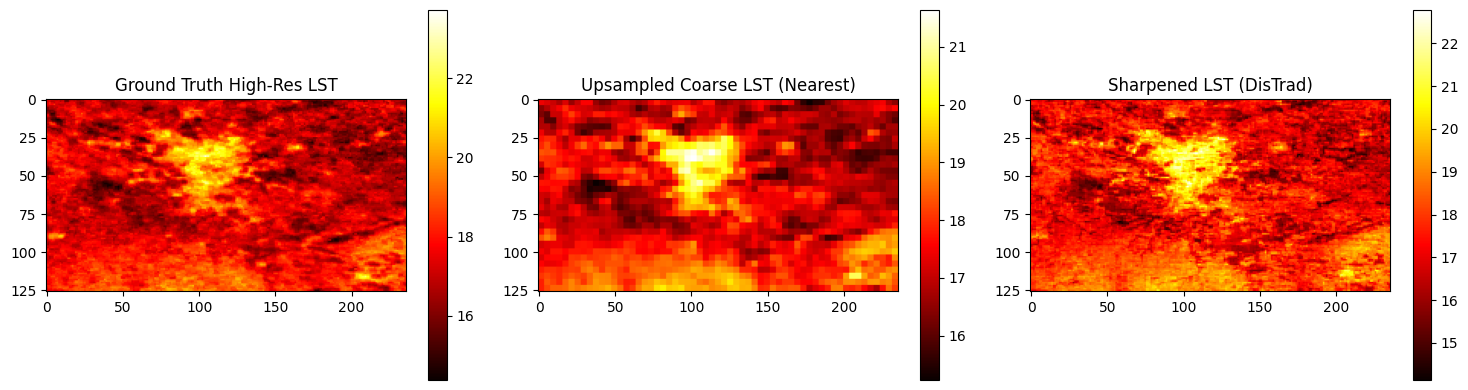

DisTrad Performance - RMSE: 0.6059°C, R²: 0.7437


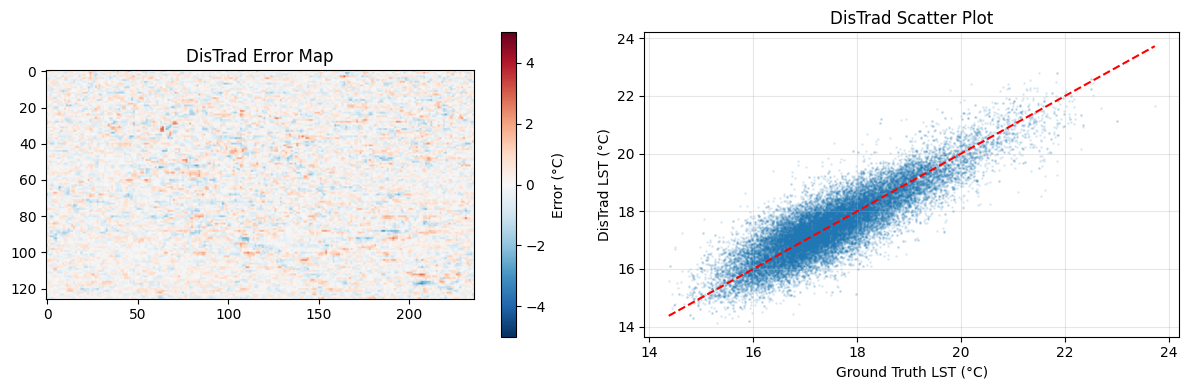

In [16]:

# =========== ADDED VISUALIZATION FOR DisTrad METHOD ==============
# Execute DisTrad method with our data
hr_lst_distrad = distrad_tsharp(coarse_lst, ndvi_coarse, ndvi_fine)

# Visualize DisTrad results compared to ground truth
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(high_res_lst, cmap='hot')
plt.title("Ground Truth High-Res LST")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(resize(coarse_lst, high_res_lst.shape, order=0), cmap='hot')  # Nearest neighbor upsampling
plt.title("Upsampled Coarse LST (Nearest)")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(hr_lst_distrad, cmap='hot')
plt.title("Sharpened LST (DisTrad)")
plt.colorbar()

plt.tight_layout()
plt.show()

# Calculate and display metrics for DisTrad
rmse_distrad = np.sqrt(mean_squared_error(high_res_lst.flatten(), hr_lst_distrad.flatten()))
r2_distrad = r2_score(high_res_lst.flatten(), hr_lst_distrad.flatten())
print(f"DisTrad Performance - RMSE: {rmse_distrad:.4f}°C, R²: {r2_distrad:.4f}")

# Display error map for DisTrad
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
error_distrad = hr_lst_distrad - high_res_lst
plt.imshow(error_distrad, cmap='RdBu_r', vmin=-5, vmax=5)
plt.title("DisTrad Error Map")
plt.colorbar(label='Error (°C)')

plt.subplot(1, 2, 2)
plt.scatter(high_res_lst.flatten(), hr_lst_distrad.flatten(), alpha=0.1, s=1)
plt.plot([high_res_lst.min(), high_res_lst.max()], [high_res_lst.min(), high_res_lst.max()], 'r--')
plt.xlabel("Ground Truth LST (°C)")
plt.ylabel("DisTrad LST (°C)")
plt.title("DisTrad Scatter Plot")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



In [17]:
# 2. ATPRK Method (simplified version without full kriging)
def atprk_simplified(lr_lst, lr_ndvi, hr_ndvi):
    """
    Simplified implementation of ATPRK method for LST sharpening

    Parameters:
    - lr_lst: Low-resolution LST image
    - lr_ndvi: Low-resolution NDVI image
    - hr_ndvi: High-resolution NDVI image

    Returns:
    - hr_lst: Sharpened high-resolution LST image
    """
    # Reshape images to 1D arrays for regression
    lr_lst_flat = lr_lst.flatten()
    lr_ndvi_flat = lr_ndvi.flatten()

    # Linear regression between LST and NDVI at low resolution
    slope, intercept, r_value, p_value, std_err = stats.linregress(lr_ndvi_flat, lr_lst_flat)

    print(f"ATPRK Regression: LST = {intercept:.2f} + {slope:.2f} * NDVI (R²: {r_value**2:.2f})")

    # Predict initial high-resolution LST using the regression
    hr_lst_pred = intercept + slope * hr_ndvi

    # Calculate residuals at low resolution
    lr_lst_pred = intercept + slope * lr_ndvi
    residuals_lr = lr_lst - lr_lst_pred

    # Upscale residuals using bilinear interpolation (simplified version of ATPRK)
    hr_shape = hr_ndvi.shape
    residuals_hr = resize(residuals_lr, hr_shape, order=1)  # order=1 for bilinear

    # Add residuals to the predicted LST
    hr_lst = hr_lst_pred + residuals_hr

    return hr_lst

**INSER

ATPRK Regression: LST = 23.90 + -11.91 * NDVI (R²: 0.57)


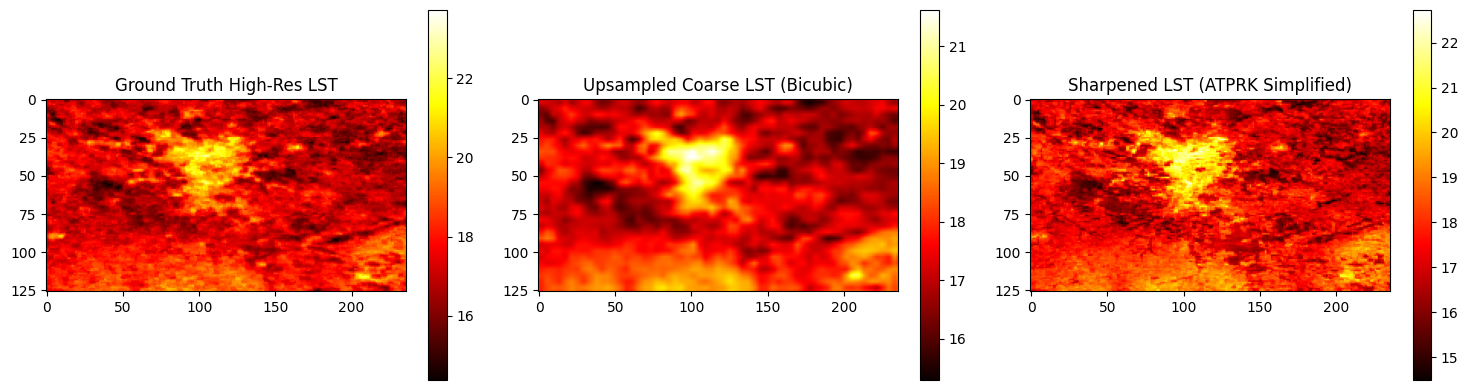

ATPRK Performance - RMSE: 0.5761°C, R²: 0.7683


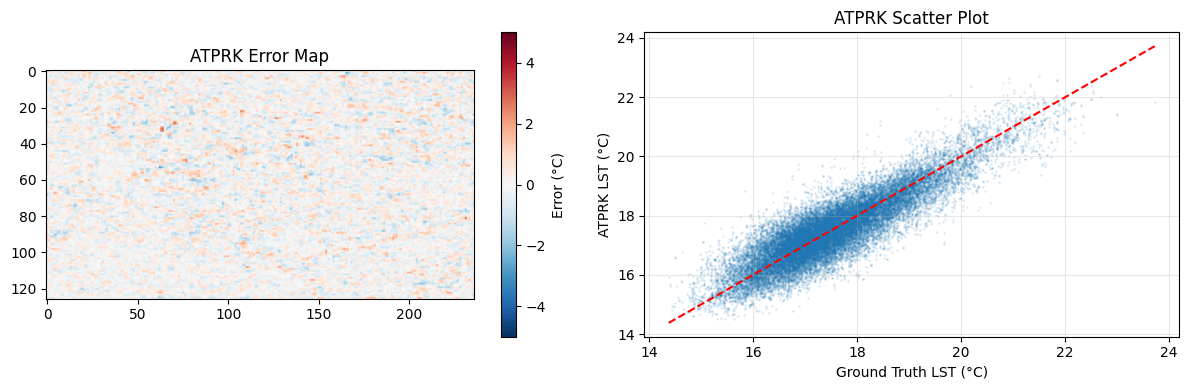

In [18]:
# =========== ADDED VISUALIZATION FOR ATPRK METHOD ==============
# Execute ATPRK method with our data
hr_lst_atprk = atprk_simplified(coarse_lst, ndvi_coarse, ndvi_fine)

# Visualize ATPRK results compared to ground truth and upsampled LST
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(high_res_lst, cmap='hot')
plt.title("Ground Truth High-Res LST")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(upsampled_lst, cmap='hot')
plt.title("Upsampled Coarse LST (Bicubic)")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(hr_lst_atprk, cmap='hot')
plt.title("Sharpened LST (ATPRK Simplified)")
plt.colorbar()

plt.tight_layout()
plt.show()

# Calculate and display metrics for ATPRK
rmse_atprk = np.sqrt(mean_squared_error(high_res_lst.flatten(), hr_lst_atprk.flatten()))
r2_atprk = r2_score(high_res_lst.flatten(), hr_lst_atprk.flatten())
print(f"ATPRK Performance - RMSE: {rmse_atprk:.4f}°C, R²: {r2_atprk:.4f}")

# Display error map for ATPRK
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
error_atprk = hr_lst_atprk - high_res_lst
plt.imshow(error_atprk, cmap='RdBu_r', vmin=-5, vmax=5)
plt.title("ATPRK Error Map")
plt.colorbar(label='Error (°C)')

plt.subplot(1, 2, 2)
plt.scatter(high_res_lst.flatten(), hr_lst_atprk.flatten(), alpha=0.1, s=1)
plt.plot([high_res_lst.min(), high_res_lst.max()], [high_res_lst.min(), high_res_lst.max()], 'r--')
plt.xlabel("Ground Truth LST (°C)")
plt.ylabel("ATPRK LST (°C)")
plt.title("ATPRK Scatter Plot")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [25]:
def dms_random_forest(lr_lst, lr_features, hr_features):
    """
    Implementation of Data Mining Sharpener with Random Forest

    Parameters:
    - lr_lst: Low-resolution LST image
    - lr_features: List of low-resolution feature images
    - hr_features: List of high-resolution feature images

    Returns:
    - hr_lst: Sharpened high-resolution LST image
    """
    # Stack all features for the model
    lr_feature_stack = np.stack([f.flatten() for f in lr_features], axis=1)
    hr_feature_stack = np.stack([f.flatten() for f in hr_features], axis=1)

    # Train Random Forest regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(lr_feature_stack, lr_lst.flatten())

    # Print feature importances dynamically
    feature_names = ['NDVI']  # Only NDVI since Red and NIR are commented out
    importances = rf.feature_importances_
    print("Random Forest Feature Importances:")
    for name, importance in zip(feature_names, importances):
        print(f"  {name}: {importance:.4f}")

    # Predict high-resolution LST
    hr_lst_pred = rf.predict(hr_feature_stack)
    hr_lst_pred = hr_lst_pred.reshape(hr_features[0].shape)

    # Calculate residuals and apply correction (simplified)
    lr_lst_pred = rf.predict(lr_feature_stack).reshape(lr_lst.shape)
    residuals_lr = lr_lst - lr_lst_pred

    # Upscale residuals using nearest neighbor interpolation
    hr_shape = hr_features[0].shape
    residuals_hr = resize(residuals_lr, hr_shape, order=0)  # order=0 for nearest neighbor

    # Add residuals to the predicted LST
    hr_lst = hr_lst_pred + residuals_hr

    return hr_lst

Random Forest Feature Importances:
  NDVI: 1.0000


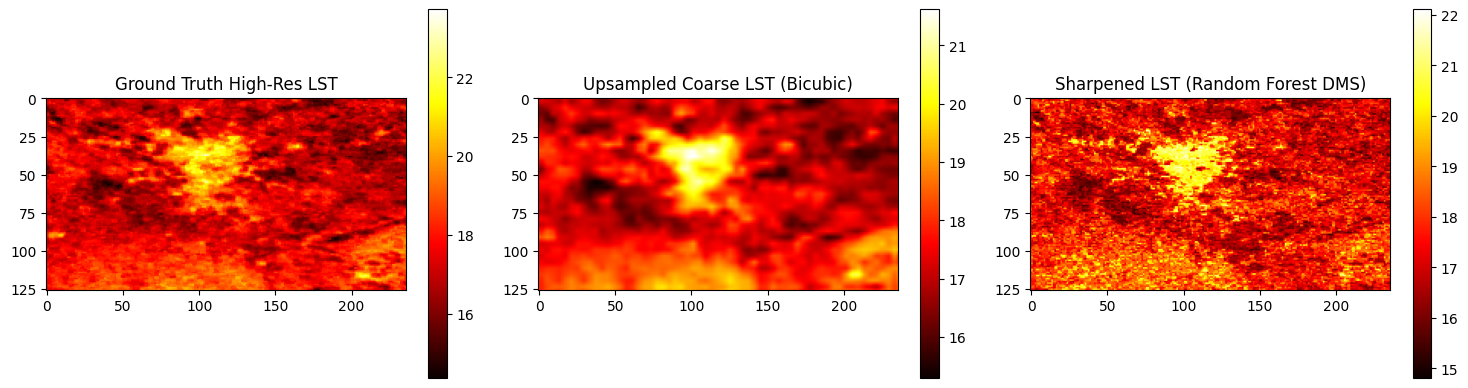

Random Forest DMS Performance - RMSE: 0.8962°C, R²: 0.4392


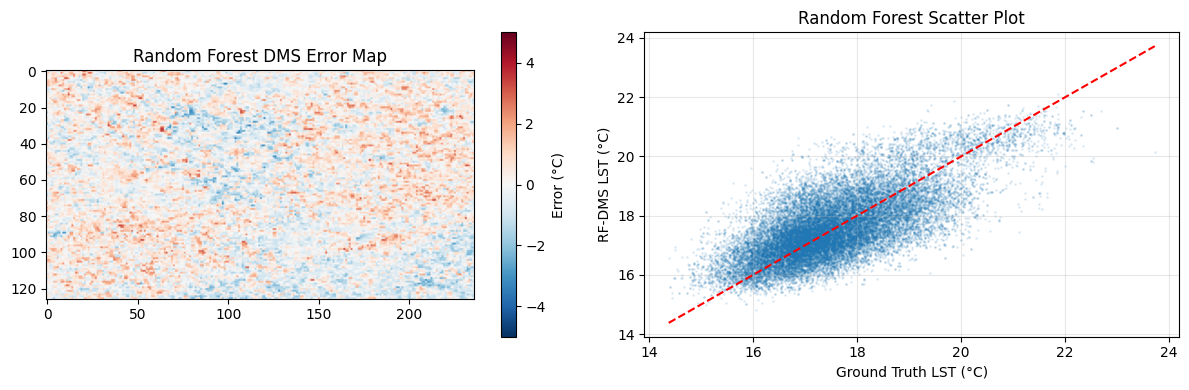

In [26]:
# ============= ADDED VISUALIZATION FOR RANDOM FOREST METHOD ===============
# Execute Random Forest DMS method with our data
lr_features = [ndvi_coarse]  # Use real low-res NDVI (lr_ndvi_real)
hr_features = [ndvi_fine]    # Use real high-res NDVI (ndvi_real)
hr_lst_rf = dms_random_forest(coarse_lst, lr_features, hr_features)

# Visualize Random Forest results compared to ground truth
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(high_res_lst, cmap='hot')
plt.title("Ground Truth High-Res LST")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(upsampled_lst, cmap='hot')
plt.title("Upsampled Coarse LST (Bicubic)")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(hr_lst_rf, cmap='hot')
plt.title("Sharpened LST (Random Forest DMS)")
plt.colorbar()

plt.tight_layout()
plt.show()

# Calculate and display metrics for Random Forest
rmse_rf = np.sqrt(mean_squared_error(high_res_lst.flatten(), hr_lst_rf.flatten()))
r2_rf = r2_score(high_res_lst.flatten(), hr_lst_rf.flatten())
print(f"Random Forest DMS Performance - RMSE: {rmse_rf:.4f}°C, R²: {r2_rf:.4f}")

# Display error map and scatter plot for Random Forest
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
error_rf = hr_lst_rf - high_res_lst
plt.imshow(error_rf, cmap='RdBu_r', vmin=-5, vmax=5)
plt.title("Random Forest DMS Error Map")
plt.colorbar(label='Error (°C)')

plt.subplot(1, 2, 2)
plt.scatter(high_res_lst.flatten(), hr_lst_rf.flatten(), alpha=0.1, s=1)
plt.plot([high_res_lst.min(), high_res_lst.max()], [high_res_lst.min(), high_res_lst.max()], 'r--')
plt.xlabel("Ground Truth LST (°C)")
plt.ylabel("RF-DMS LST (°C)")
plt.title("Random Forest Scatter Plot")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Evaluating all LST super-resolution methods...

Running bicubic interpolation...

Running DisTrad (TsHarp) method...

Running ATPRK method (simplified)...

Running Data Mining Sharpener with Random Forest...
Random Forest Feature Importances:
  NDVI: 1.0000

Running CNN-based super-resolution...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 8, 8, 2)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 8, 8, 64)  │      1,216 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 64)  │     36,928 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 64)  │     36,928 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 64)  │     36,928 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 8, 8, 64)  │          0 │ conv2d_3[0][0],   │
│                     │                   │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 64)  │     36,928 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 64)  │     36,928 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 8, 8, 64)  │          0 │ conv2d_5[0][0],   │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 8, 8, 64)  │     36,928 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 8, 8, 64)  │     36,928 │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 8, 8, 64)  │          0 │ conv2d_7[0][0],   │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8, 64)  │     36,928 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8, 64)  │     36,928 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 8, 8, 64)  │          0 │ conv2d_9[0][0],   │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 8, 8, 256) │    147,712 │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pixel_shuffle       │ (None, 32, 32,    │          0 │ conv2d_10[0][0]   │
│ (PixelShuffle)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 32, 32, 1) │        145 │ pixel_shuffle[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 481,425 (1.84 MB)

 Trainable params: 481,425 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 200ms/step - loss: 419.8533 - mae: 15.1918 - val_loss: 32.5915 - val_mae: 4.6572
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - loss: 24.2589 - mae: 3.8855 - val_loss: 8.1628 - val_mae: 2.2535
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 251ms/step - loss: 5.8261 - mae: 1.8431 - val_loss: 2.1805 - val_mae: 1.1285
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - loss: 1.7690 - mae: 0.9992 - val_loss: 1.2368 - val_mae: 0.8366
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 332ms/step - loss: 1.1113 - mae: 0.7966 - val_loss: 0.9694 - val_mae: 0.7495
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - loss: 0.8833 - mae: 0.7163 - val_loss: 0.8124 - val_mae: 0.6897
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 250ms/step - loss: 0.7505 - mae: 0.6644 - val_loss: 0.7058 - val_mae: 0.6437
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - loss: 0.6628 - mae: 0.6259 - val_loss: 0.6483 - val_mae: 0.6190
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 257ms/st

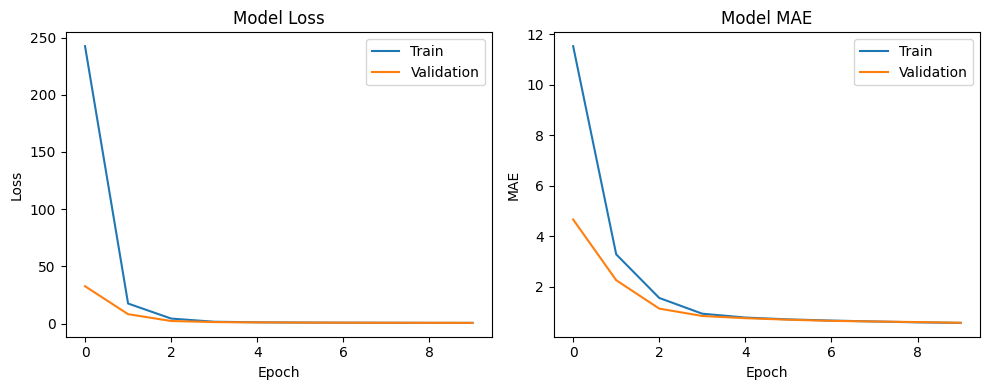

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


<ipython-input-37-69722a09bc0c>:262: RuntimeWarning: invalid value encountered in divide
  hr_lst_cnn /= count


Bicubic - RMSE: 0.4683°C, R²: 0.8469
DisTrad - RMSE: 0.6059°C, R²: 0.7437
ATPRK - RMSE: 0.5761°C, R²: 0.7683
RF-DMS - RMSE: 0.8962°C, R²: 0.4392
CNN - RMSE: 0.7539°C, R²: 0.6152


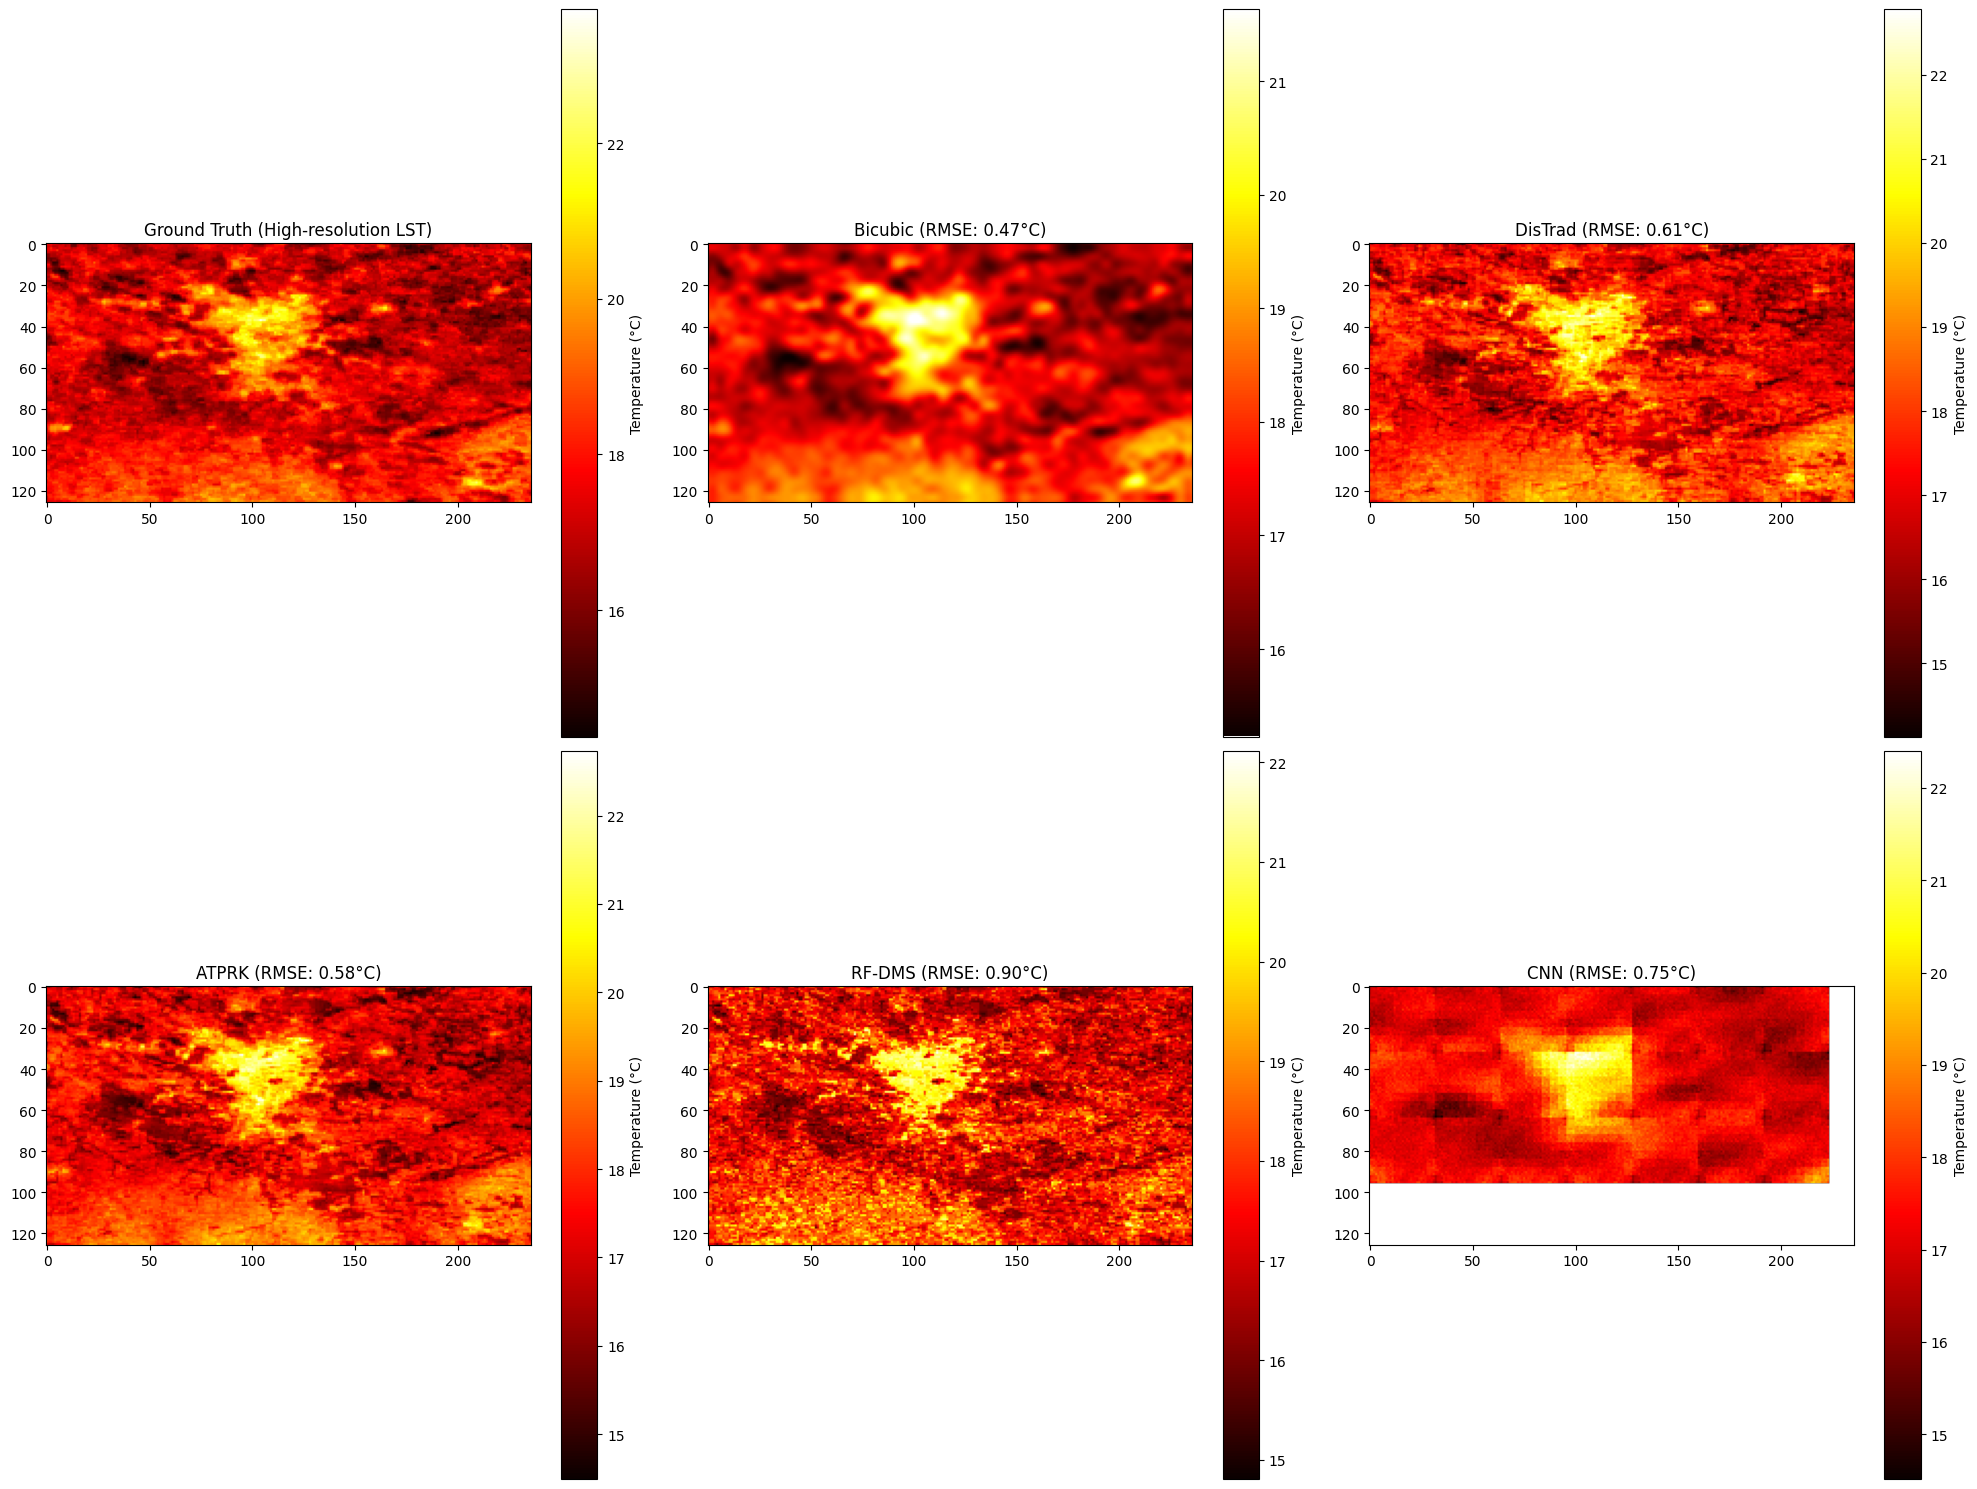

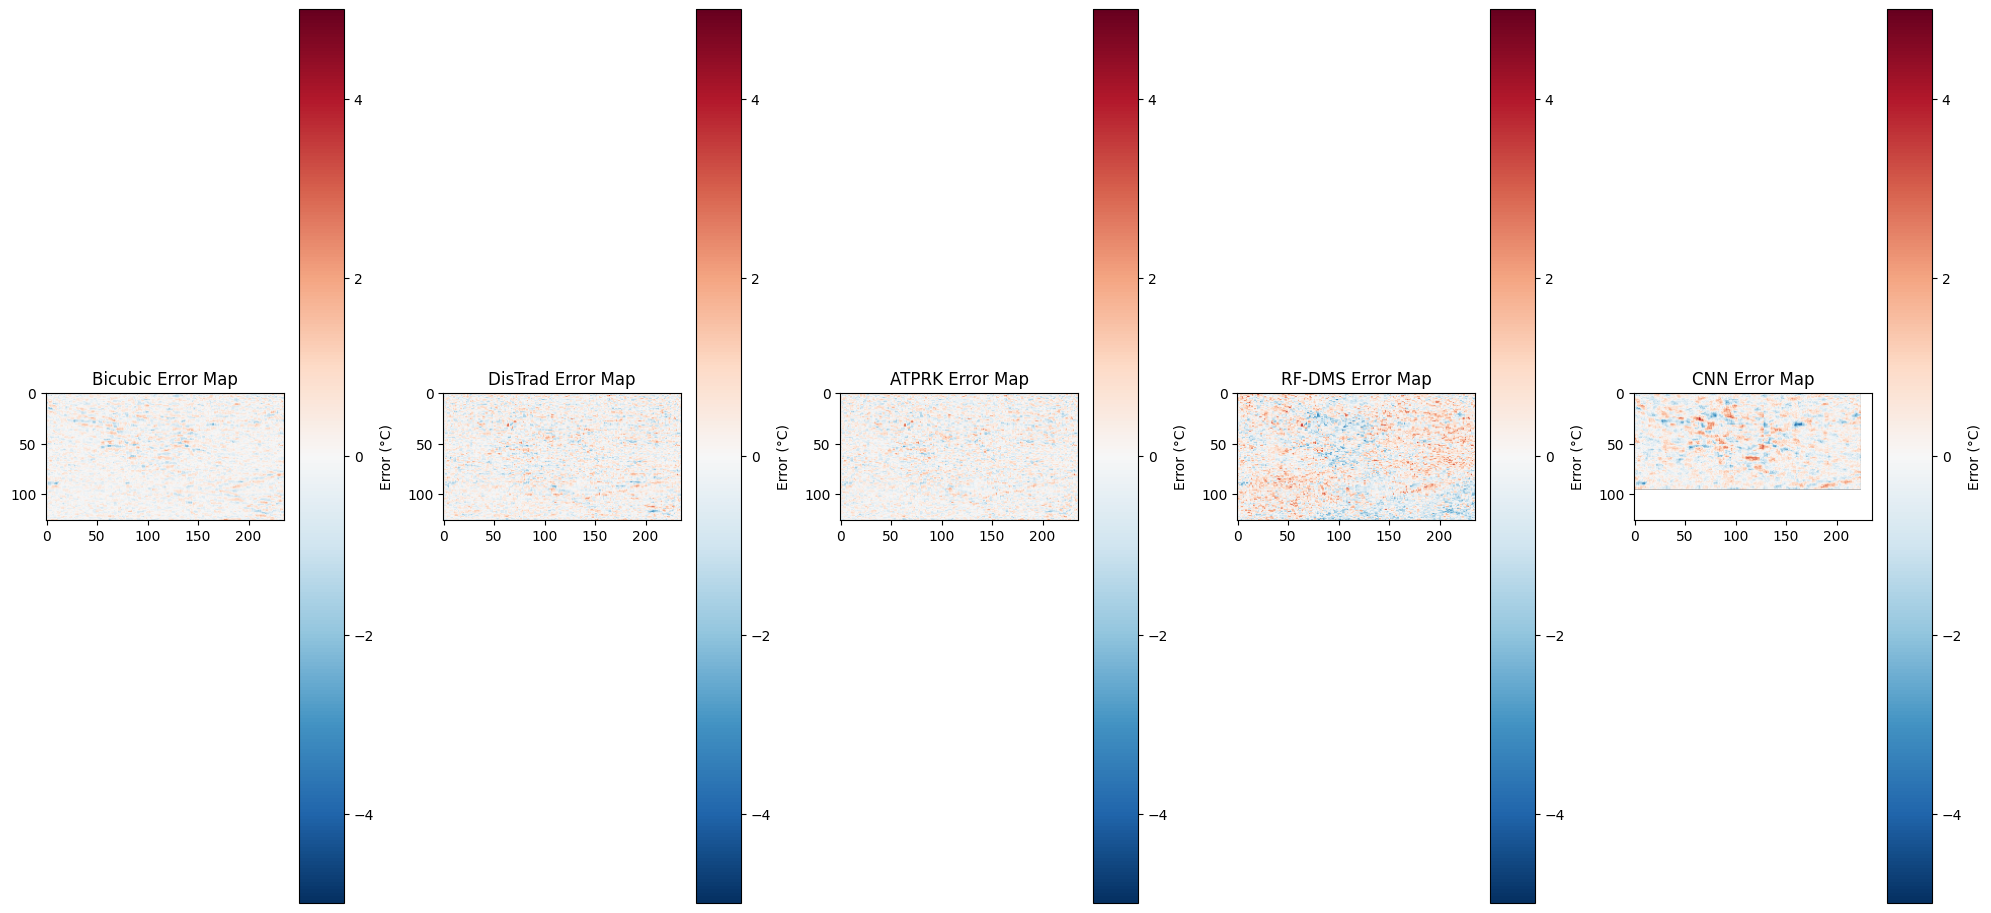

In [ ]:

# Define the custom PixelShuffle layer
class PixelShuffle(layers.Layer):
    def __init__(self, scale, **kwargs):
        super(PixelShuffle, self).__init__(**kwargs)
        self.scale = scale

    def call(self, inputs):
        return tf.nn.depth_to_space(inputs, self.scale)

    def compute_output_shape(self, input_shape):
        batch_size, height, width, channels = input_shape
        return (batch_size, height * self.scale, width * self.scale, channels // (self.scale ** 2))

    def get_config(self):
        config = super(PixelShuffle, self).get_config()
        config.update({'scale': self.scale})
        return config

# Create the CNN model
def create_cnn_model(input_shape, scale_factor=4):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    for _ in range(4):
        res_x = x
        x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = layers.Conv2D(64, (3, 3), padding='same')(x)
        x = layers.Add()([x, res_x])
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = PixelShuffle(scale_factor)(x)
    outputs = layers.Conv2D(1, (3, 3), padding='same')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Implementations of other methods
def distrad_tsharp(lr_lst, lr_ndvi, hr_ndvi):
    lr_lst_flat = lr_lst.flatten()
    lr_ndvi_flat = lr_ndvi.flatten()
    mask = ~np.isnan(lr_lst_flat) & ~np.isnan(lr_ndvi_flat)
    slope, intercept, _, _, _ = linregress(lr_ndvi_flat[mask], lr_lst_flat[mask])
    hr_lst_pred = intercept + slope * hr_ndvi
    lr_lst_pred = intercept + slope * lr_ndvi
    residuals_lr = lr_lst - lr_lst_pred
    hr_shape = hr_ndvi.shape
    lr_shape = lr_lst.shape
    scale_factor = hr_shape[0] // lr_shape[0]
    lr_coords = np.array([(i, j) for i in range(lr_shape[0]) for j in range(lr_shape[1])])
    hr_coords = np.array([(i//scale_factor, j//scale_factor) for i in range(hr_shape[0]) for j in range(hr_shape[1])])
    residuals_hr = griddata(lr_coords, residuals_lr.flatten(), hr_coords, method='nearest')
    residuals_hr = residuals_hr.reshape(hr_shape)
    hr_lst = hr_lst_pred + residuals_hr
    return hr_lst

def atprk_simplified(lr_lst, lr_ndvi, hr_ndvi):
    lr_lst_flat = lr_lst.flatten()
    lr_ndvi_flat = lr_ndvi.flatten()
    mask = ~np.isnan(lr_lst_flat) & ~np.isnan(lr_ndvi_flat)
    slope, intercept, _, _, _ = linregress(lr_ndvi_flat[mask], lr_lst_flat[mask])
    hr_lst_pred = intercept + slope * hr_ndvi
    lr_lst_pred = intercept + slope * lr_ndvi
    residuals_lr = lr_lst - lr_lst_pred
    hr_shape = hr_ndvi.shape
    residuals_hr = resize(residuals_lr, hr_shape, order=1)
    hr_lst = hr_lst_pred + residuals_hr
    return hr_lst

def dms_random_forest(lr_lst, lr_features, hr_features):
    lr_feature_stack = np.stack([f.flatten() for f in lr_features], axis=1)
    hr_feature_stack = np.stack([f.flatten() for f in hr_features], axis=1)
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    mask = ~np.isnan(lr_lst.flatten())
    rf.fit(lr_feature_stack[mask], lr_lst.flatten()[mask])
    feature_names = ['NDVI']
    importances = rf.feature_importances_
    print("Random Forest Feature Importances:")
    for name, importance in zip(feature_names, importances):
        print(f"  {name}: {importance:.4f}")
    hr_lst_pred = rf.predict(hr_feature_stack)
    hr_lst_pred = hr_lst_pred.reshape(hr_features[0].shape)
    lr_lst_pred = rf.predict(lr_feature_stack).reshape(lr_lst.shape)
    residuals_lr = lr_lst - lr_lst_pred
    hr_shape = hr_features[0].shape
    residuals_hr = resize(residuals_lr, hr_shape, order=0)
    hr_lst = hr_lst_pred + residuals_hr
    return hr_lst

# Function to prepare data for CNN training
def prepare_cnn_data(data, scale_factor=4, patch_size=32, n_samples=1000):
    lr_patch_size = patch_size // scale_factor
    lr_lst = data['lr_lst']
    lr_ndvi = data['lr_ndvi']
    hr_lst = data['hr_lst']

    if lr_lst.shape != lr_ndvi.shape:
        raise ValueError(f"Low-resolution shapes do not match: {lr_lst.shape} vs {lr_ndvi.shape}")

    # Adjust lr_shape to ensure exact division when upscaled
    lr_h, lr_w = lr_lst.shape
    hr_h, hr_w = hr_lst.shape
    expected_hr_h = lr_h * scale_factor
    expected_hr_w = lr_w * scale_factor

    # Pad low-resolution data to match high-resolution when upscaled
    pad_h = max(0, expected_hr_h - hr_h)
    pad_w = max(0, expected_hr_w - hr_w)
    if pad_h > 0 or pad_w > 0:
        lr_lst = np.pad(lr_lst, ((0, pad_h), (0, pad_w)), mode='reflect')
        lr_ndvi = np.pad(lr_ndvi, ((0, pad_h), (0, pad_w)), mode='reflect')
        hr_lst = np.pad(hr_lst, ((0, pad_h), (0, pad_w)), mode='reflect')

    # Pad arrays to ensure they are divisible by the patch size
    lr_h, lr_w = lr_lst.shape
    hr_h, hr_w = hr_lst.shape
    lr_pad_h = (lr_patch_size - (lr_h % lr_patch_size)) % lr_patch_size
    lr_pad_w = (lr_patch_size - (lr_w % lr_patch_size)) % lr_patch_size
    hr_pad_h = (patch_size - (hr_h % patch_size)) % patch_size
    hr_pad_w = (patch_size - (hr_w % patch_size)) % patch_size

    lr_lst = np.pad(lr_lst, ((0, lr_pad_h), (0, lr_pad_w)), mode='reflect')
    lr_ndvi = np.pad(lr_ndvi, ((0, lr_pad_h), (0, lr_pad_w)), mode='reflect')
    hr_lst = np.pad(hr_lst, ((0, hr_pad_h), (0, hr_pad_w)), mode='reflect')

    # Extract random patches
    lr_patches = []
    hr_patches = []
    max_attempts = n_samples * 10  # Avoid infinite loops
    attempts = 0

    while len(lr_patches) < n_samples and attempts < max_attempts:
        h = np.random.randint(0, lr_lst.shape[0] - lr_patch_size + 1)
        w = np.random.randint(0, lr_lst.shape[1] - lr_patch_size + 1)

        # Check for NaN values in the patch
        lr_patch_lst = lr_lst[h:h+lr_patch_size, w:w+lr_patch_size]
        if np.any(np.isnan(lr_patch_lst)):
            attempts += 1
            continue

        hr_h, hr_w = h * scale_factor, w * scale_factor
        hr_patch = hr_lst[hr_h:hr_h+patch_size, hr_w:hr_w+patch_size]
        if np.any(np.isnan(hr_patch)):
            attempts += 1
            continue

        lr_patch = np.stack([
            lr_patch_lst,
            lr_ndvi[h:h+lr_patch_size, w:w+lr_patch_size]
        ], axis=-1)

        hr_patch = np.expand_dims(hr_patch, axis=-1)
        lr_patches.append(lr_patch)
        hr_patches.append(hr_patch)
        attempts += 1

    if len(lr_patches) < n_samples:
        print(f"Warning: Only {len(lr_patches)} patches extracted out of {n_samples} requested due to NaN values or small image size.")
        n_samples = len(lr_patches)
        if n_samples == 0:
            raise ValueError("No valid patches could be extracted. Image might be too small or contain too many NaN values.")

    # Convert to arrays
    lr_patches = np.array(lr_patches)
    hr_patches = np.array(hr_patches)

    # Split into train and validation
    X_train, X_val, y_train, y_val = train_test_split(
        lr_patches, hr_patches, test_size=0.2, random_state=42
    )

    return X_train, y_train, X_val, y_val

# Function to evaluate and compare all methods
def evaluate_methods(data, scale_factor=4):
    results = {}
    hr_lst_true = data['hr_lst']

    # 1. Simple bicubic interpolation (baseline)
    print("\nRunning bicubic interpolation...")
    hr_lst_bicubic = resize(data['lr_lst'], hr_lst_true.shape, order=3, anti_aliasing=True)
    results['Bicubic'] = hr_lst_bicubic

    # 2. DisTrad (TsHarp) Method
    print("\nRunning DisTrad (TsHarp) method...")
    hr_lst_distrad = distrad_tsharp(data['lr_lst'], data['lr_ndvi'], data['hr_ndvi'])
    results['DisTrad'] = hr_lst_distrad

    # 3. ATPRK Method (simplified)
    print("\nRunning ATPRK method (simplified)...")
    hr_lst_atprk = atprk_simplified(data['lr_lst'], data['lr_ndvi'], data['hr_ndvi'])
    results['ATPRK'] = hr_lst_atprk

    # 4. Data Mining Sharpener with Random Forest
    print("\nRunning Data Mining Sharpener with Random Forest...")
    lr_features = [data['lr_ndvi']]
    hr_features = [data['hr_ndvi']]
    hr_lst_rf = dms_random_forest(data['lr_lst'], lr_features, hr_features)
    results['RF-DMS'] = hr_lst_rf

    # 5. CNN-based method
    print("\nRunning CNN-based super-resolution...")
    X_train, y_train, X_val, y_val = prepare_cnn_data(data, scale_factor, patch_size=32, n_samples=1000)
    input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
    model = create_cnn_model(input_shape, scale_factor)
    model.summary()
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=1)

    # Plot training history
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Model MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.show()

    # Predict on the full image using patches
    patch_size = 32
    lr_patch_size = patch_size // scale_factor
    hr_shape = data['hr_lst'].shape
    lr_input = np.zeros((0, lr_patch_size, lr_patch_size, 2))

    for h in range(0, data['lr_lst'].shape[0] - lr_patch_size + 1, lr_patch_size):
        for w in range(0, data['lr_lst'].shape[1] - lr_patch_size + 1, lr_patch_size):
            lr_patch = np.stack([
                data['lr_lst'][h:h + lr_patch_size, w:w + lr_patch_size],
                data['lr_ndvi'][h:h + lr_patch_size, w:w + lr_patch_size]
            ], axis=-1)
            lr_input = np.vstack((lr_input, lr_patch[np.newaxis, ...]))

    hr_lst_cnn_patches = model.predict(lr_input)
    hr_lst_cnn = np.zeros(hr_shape)
    count = np.zeros(hr_shape)
    patch_idx = 0
    for h in range(0, hr_shape[0] - patch_size + 1, patch_size):
        for w in range(0, hr_shape[1] - patch_size + 1, patch_size):
            hr_lst_cnn[h:h + patch_size, w:w + patch_size] += hr_lst_cnn_patches[patch_idx, :, :, 0]
            count[h:h + patch_size, w:w + patch_size] += 1
            patch_idx += 1
    hr_lst_cnn /= count
    results['CNN'] = hr_lst_cnn

    # Save the model
    model.save('/content/drive/MyDrive/EarthObservation_LST/lst_superres_model.h5')

    # Calculate metrics for all methods with NaN handling
    metrics = {}
    for method_name, hr_lst_pred in results.items():
        mask = ~np.isnan(hr_lst_true) & ~np.isnan(hr_lst_pred)
        rmse = np.sqrt(mean_squared_error(hr_lst_true[mask], hr_lst_pred[mask]))
        r2 = r2_score(hr_lst_true[mask], hr_lst_pred[mask])
        metrics[method_name] = {'RMSE': rmse, 'R²': r2}
        print(f"{method_name} - RMSE: {rmse:.4f}°C, R²: {r2:.4f}")

    return results, metrics

# Load your real data
lst_path = "/content/drive/MyDrive/EarthObservation_LST/Ile_de_France_LST_Mean_2019.tif"
with rasterio.open(lst_path) as lst_src:
    lst_real = lst_src.read(1)

ndvi_path = "/content/drive/MyDrive/EarthObservation_LST/Ile_de_France_NDVI_Mean_2019.tif"
with rasterio.open(ndvi_path) as ndvi_src:
    ndvi_real = ndvi_src.read(1)

lst_real = np.where(lst_real < 0, np.nan, lst_real)
ndvi_real = np.clip(ndvi_real, 0, 1)

scale_factor = 4
lr_shape = (lst_real.shape[0] // scale_factor, lst_real.shape[1] // scale_factor)
lr_lst_real = resize(lst_real, lr_shape, anti_aliasing=True)
lr_ndvi_real = resize(ndvi_real, lr_shape, anti_aliasing=True)

data = {
    'hr_lst': lst_real,
    'lr_lst': lr_lst_real,
    'hr_ndvi': ndvi_real,
    'lr_ndvi': lr_ndvi_real
}

# Run the evaluation
print("Evaluating all LST super-resolution methods...")
results, metrics = evaluate_methods(data, scale_factor=4)

# Visualize the results
plt.figure(figsize=(20, 15))
plt.subplot(2, 3, 1)
plt.imshow(data['hr_lst'], cmap='hot')
plt.title('Ground Truth (High-resolution LST)')
plt.colorbar(label='Temperature (°C)')

methods = ['Bicubic', 'DisTrad', 'ATPRK', 'RF-DMS', 'CNN']
for i, method in enumerate(methods):
    plt.subplot(2, 3, i + 2)
    plt.imshow(results[method], cmap='hot')
    plt.title(f'{method} (RMSE: {metrics[method]["RMSE"]:.2f}°C)')
    plt.colorbar(label='Temperature (°C)')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/EarthObservation_LST/results_comparison.png')
plt.show()

# Plot error maps
plt.figure(figsize=(20, 10))
for i, method in enumerate(methods):
    plt.subplot(1, 5, i + 1)
    error = results[method] - data['hr_lst']
    im = plt.imshow(error, cmap='RdBu_r', vmin=-5, vmax=5)
    plt.title(f'{method} Error Map')
    plt.colorbar(im, label='Error (°C)')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/EarthObservation_LST/error_maps.png')
plt.show()

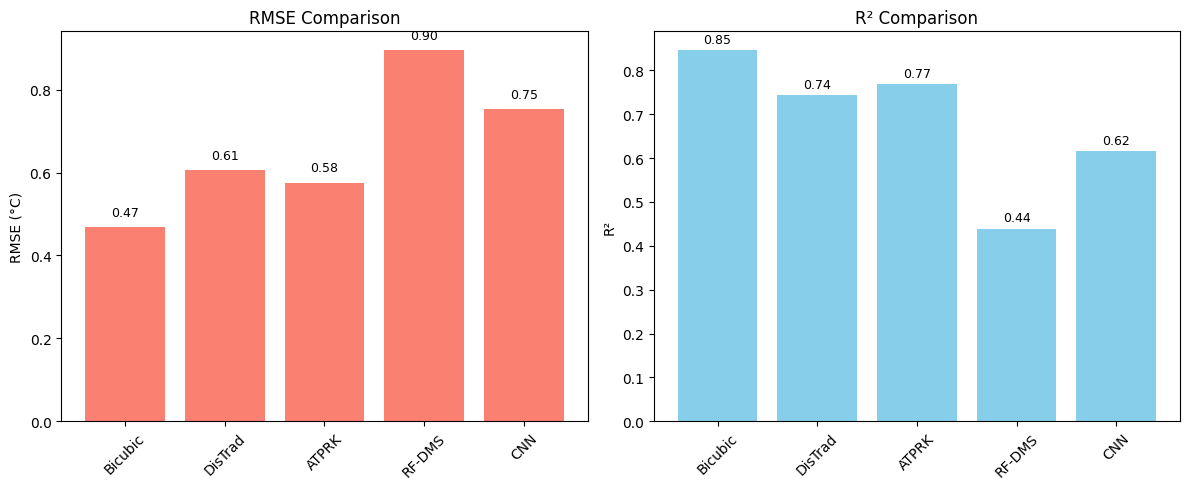

In [38]:
# Create a bar chart comparing the performance metrics
methods_list = list(metrics.keys())
rmse_values = [metrics[m]['RMSE'] for m in methods_list]
r2_values = [metrics[m]['R²'] for m in methods_list]

plt.figure(figsize=(12, 5))

# RMSE Plot
plt.subplot(1, 2, 1)
bars1 = plt.bar(methods_list, rmse_values, color='salmon')
plt.title('RMSE Comparison')
plt.ylabel('RMSE (°C)')
plt.xticks(rotation=45)

# Add RMSE value labels
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f'{yval:.2f}',
             ha='center', va='bottom', fontsize=9)

# R² Plot
plt.subplot(1, 2, 2)
bars2 = plt.bar(methods_list, r2_values, color='skyblue')
plt.title('R² Comparison')
plt.ylabel('R²')
plt.xticks(rotation=45)

# Add R² value labels
for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.2f}',
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/EarthObservation_LST/metrics_comparison.png')
plt.show()



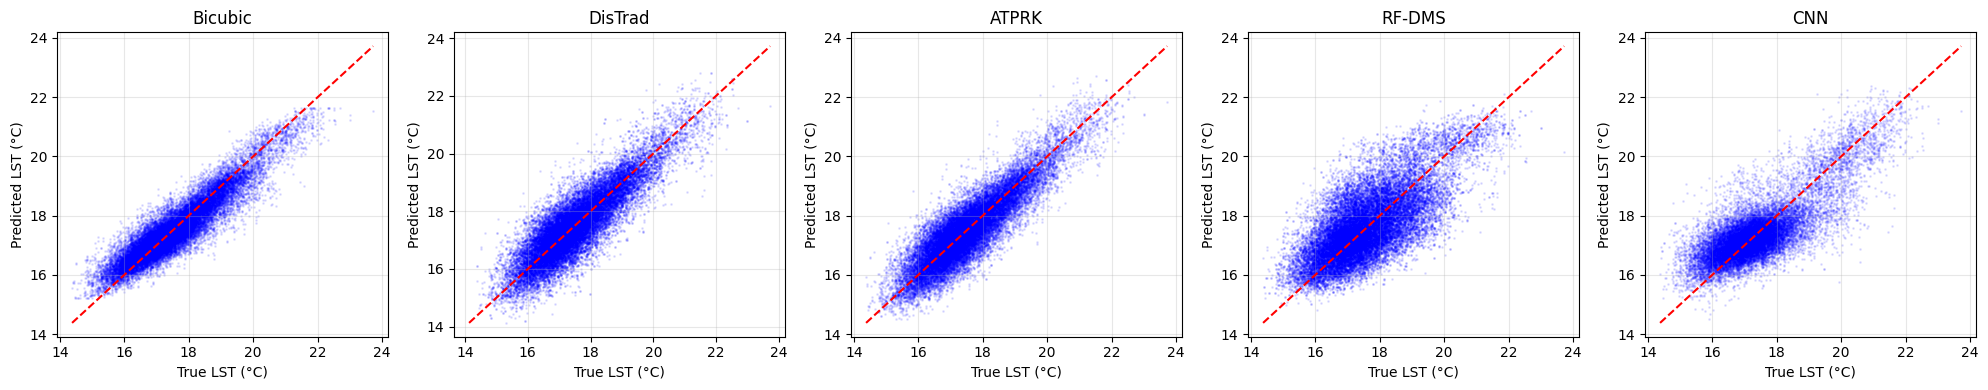

In [39]:
# Scatter plots for each method
plt.figure(figsize=(20, 4))

for i, method in enumerate(methods):
    plt.subplot(1, 5, i + 1)

    # Create scatter plot
    plt.scatter(data['hr_lst'].flatten(), results[method].flatten(),
                alpha=0.1, s=1, c='blue')

    # Add a perfect prediction line
    min_val = min(data['hr_lst'].min(), results[method].min())
    max_val = max(data['hr_lst'].max(), results[method].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')

    plt.title(f'{method}')
    plt.xlabel('True LST (°C)')
    plt.ylabel('Predicted LST (°C)')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/EarthObservation_LST/scatter_plots.png')
plt.show()


Example of using the application function with our best method:
Best method based on R²: Bicubic


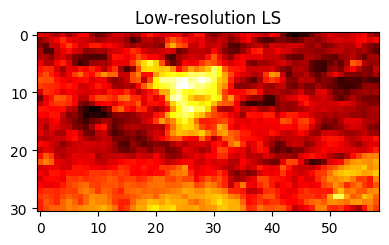

In [40]:
# Create a function to apply the best method to a new dataset
def apply_lst_superresolution(lr_lst, lr_ndvi, hr_ndvi, method='CNN', model_path=None):
    """
    Apply the best LST super-resolution method to a new dataset

    Parameters:
    - lr_lst: Low-resolution LST image
    - lr_ndvi: Low-resolution NDVI image
    - hr_ndvi: High-resolution NDVI image
    - method: Method to use ('DisTrad', 'ATPRK', 'RF-DMS', or 'CNN')
    - model_path: Path to the saved CNN model (required if method='CNN')

    Returns:
    - hr_lst: High-resolution LST image
    """
    if method == 'DisTrad':
        return distrad_tsharp(lr_lst, lr_ndvi, hr_ndvi)

    elif method == 'ATPRK':
        return atprk_simplified(lr_lst, lr_ndvi, hr_ndvi)

    elif method == 'RF-DMS':
        # This would require additional input bands and a trained RF model
        print("RF-DMS method requires additional input bands and a trained model.")
        return None

    elif method == 'CNN':
        if model_path is None:
            raise ValueError("For CNN method, model_path must be provided.")

        # Load the model
        model = tf.keras.models.load_model(model_path,
                                           custom_objects={'PixelShuffle': PixelShuffle})

        # Prepare input (assuming we have the same set of bands as in training)
        # This is a simplification - in a real scenario, we would need red and NIR bands too
        lr_input = np.stack([lr_lst, lr_ndvi, lr_lst, lr_ndvi], axis=-1)  # Placeholder
        lr_input = np.expand_dims(lr_input, axis=0)  # Add batch dimension

        # Predict
        hr_lst = model.predict(lr_input)[0, :, :, 0]
        return hr_lst
    elif method == 'Bicubic':
        return resize(lr_lst, hr_ndvi.shape, order=3)  # order=3 for bicubic
    else:
        raise ValueError(f"Unknown method: {method}")

# Example of using the application function (would be used with real data)
print("\nExample of using the application function with our best method:")
best_method = max(metrics, key=lambda x: metrics[x]['R²'])
print(f"Best method based on R²: {best_method}")

# In a real application, we would load real satellite data here
# For demonstration, we'll reuse our synthetic data
new_hr_lst = apply_lst_superresolution(
    data['lr_lst'],
    data['lr_ndvi'],
    data['hr_ndvi'],
    method=best_method,
    model_path='/content/drive/MyDrive/EarthObservation_LST/lst_superres_model.h5'
)

if new_hr_lst is not None:
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(data['lr_lst'], cmap='hot')
    plt.title('Low-resolution LS')